## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [37]:
# Camera calibration using chessboard images
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# chessboard dimensions of black square intersections
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # print(fname, ": found corners")
        # Draw and display the corners
        # img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        # plt.figure()
        # plt.imshow(img)
    else:
        pass
        # print(fname, ": corners not found")


## And so on and so forth...

In [38]:
# Correcting for distortion
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# perform camera calibration, to extract distortion and transformation matrix
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,
                                                   cv2.imread('./camera_cal/calibration1.jpg').shape[1::-1],
                                                   None, None)
# perform undistortion transformation on images
# for fname in images:
#     img = cv2.imread(fname)
#     undistorted = cv2.undistort(img, mtx, dist, None, mtx)
#     plt.figure()
#     plt.imshow(undistorted)

In [41]:
# Applying perspective transformation on chessboard images
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    p = 100
    if ret:
        undist = cv2.drawChessboardCorners(undist, (nx,ny), corners, ret)
        src = np.float32([corners[0],corners[nx-1],corners[-1],corners[-nx]])
        img_size = gray.shape[::-1]
        dst = np.float32([[p,p],[img_size[0]-p,p],[img_size[0]-p,img_size[1]-p],[p,img_size[1]-p]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        return warped, M
    else:
        return None, None

for fname in images:
    img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_RGB2BGR)
    warped, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
#    if warped is not None:
#        plt.figure()
#        plt.imshow(img)
#        plt.figure()
#        plt.imshow(warped)
#    else:
#        print(fname, ": no success warping")

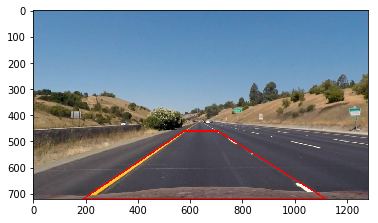

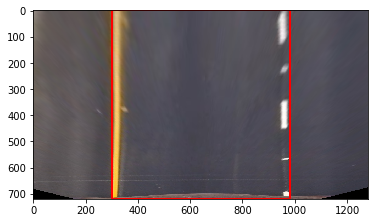

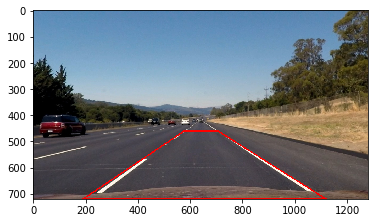

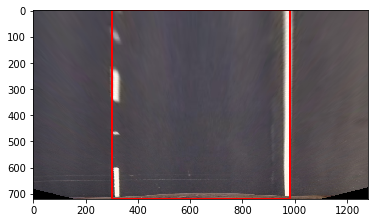

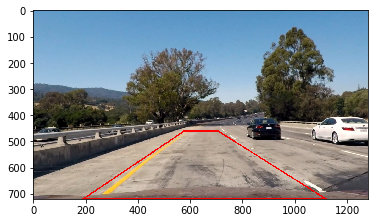

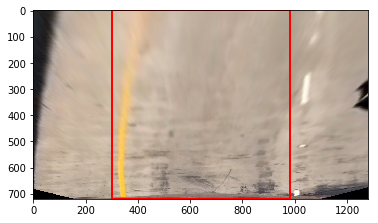

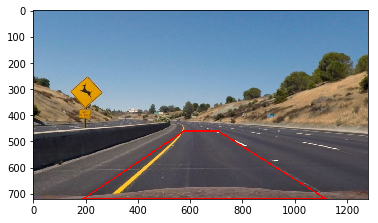

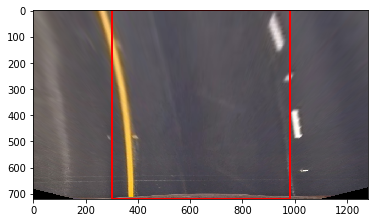

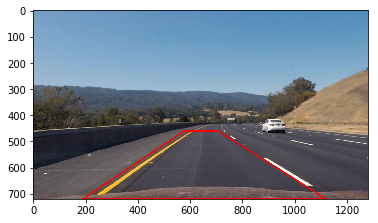

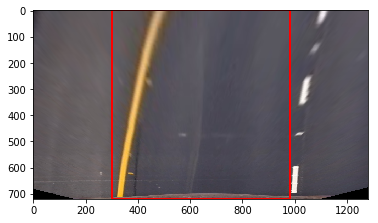

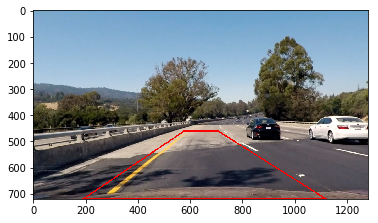

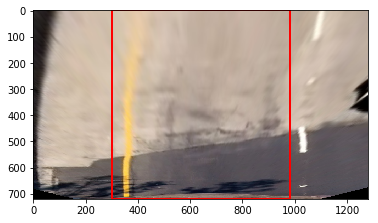

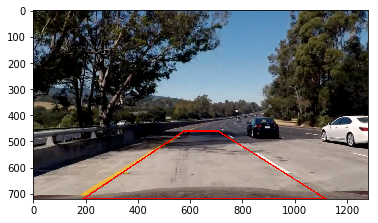

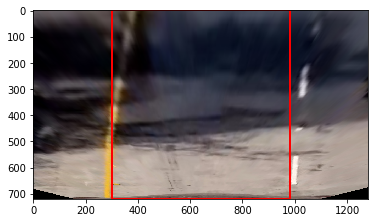

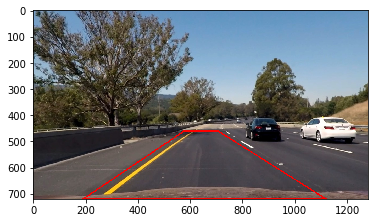

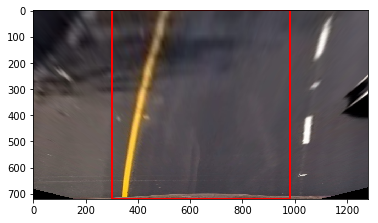

In [73]:
# Applying perspective transformation on road images
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# source points: top left, top right, bottom right, bottom left
src = np.float32([[578, 460], [706, 460], [1120, 720], [190, 720]])
pts1 = np.array(src, np.int32).reshape(-1,1,2)

images = glob.glob('./test_images/*.jpg')
img_size = cv2.imread(images[0]).shape[1::-1]
p = 300
# destination points: top left, top right, bottom right, bottom left
dst = np.float32([[p,0],[img_size[0]-p,0],[img_size[0]-p,img_size[1]],[p,img_size[1]]])
pts2 = np.array(dst, np.int32).reshape(-1,1,2)

warped_images = []
for fname in images:
    img = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_RGB2BGR)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    undist_rect = np.copy(undist)
    undist_rect = cv2.polylines(undist_rect,[pts1],True,(255, 0, 0),3)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    warped_images.append(warped)
    warped_rect = np.copy(warped)
    warped_rect = cv2.polylines(warped_rect,[pts2],True,(255, 0, 0),6)
    if warped is not None:
        plt.figure()
        plt.imshow(undist_rect)
        plt.figure()
        plt.imshow(warped_rect)
    else:
        print(fname, ": no success warping")

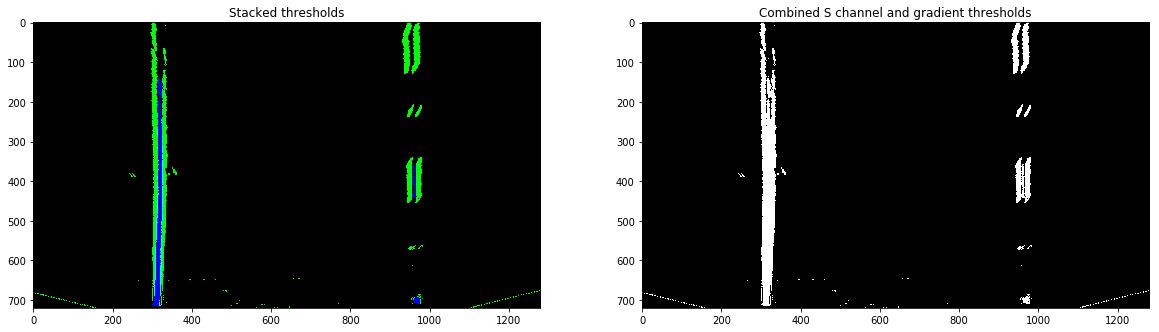

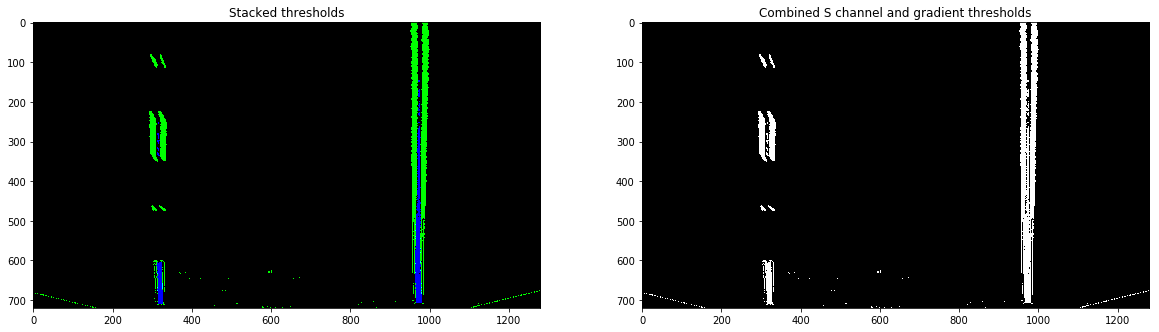

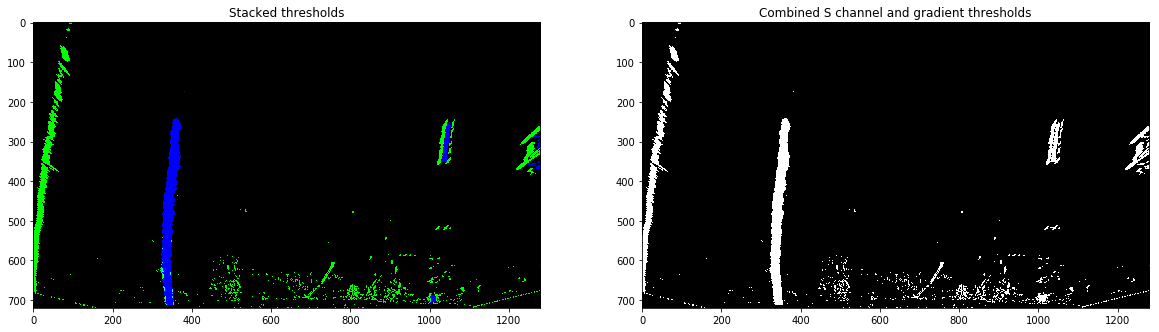

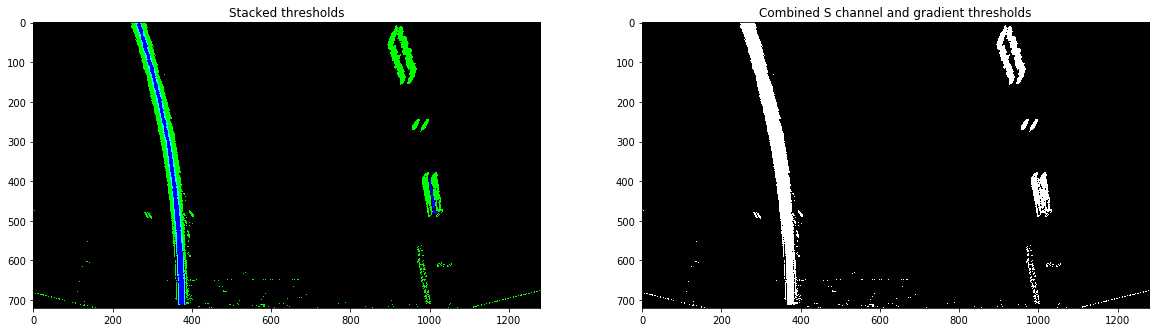

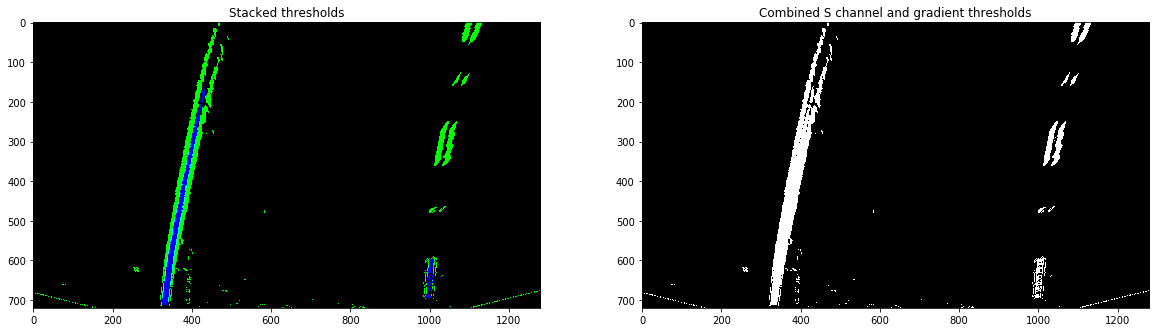

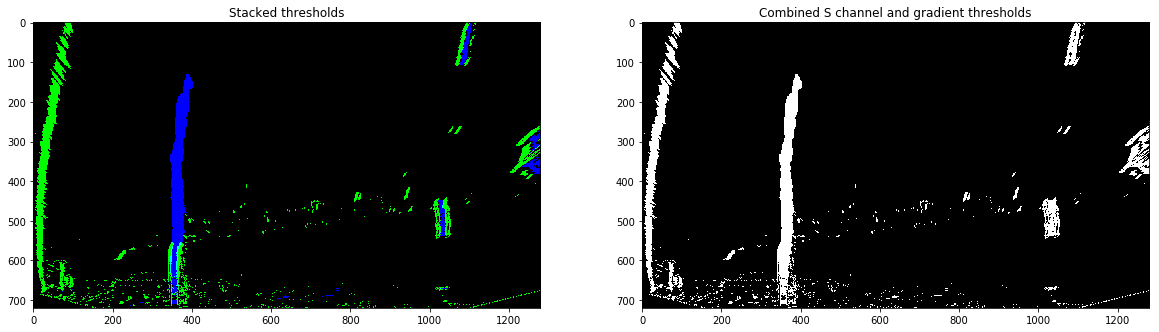

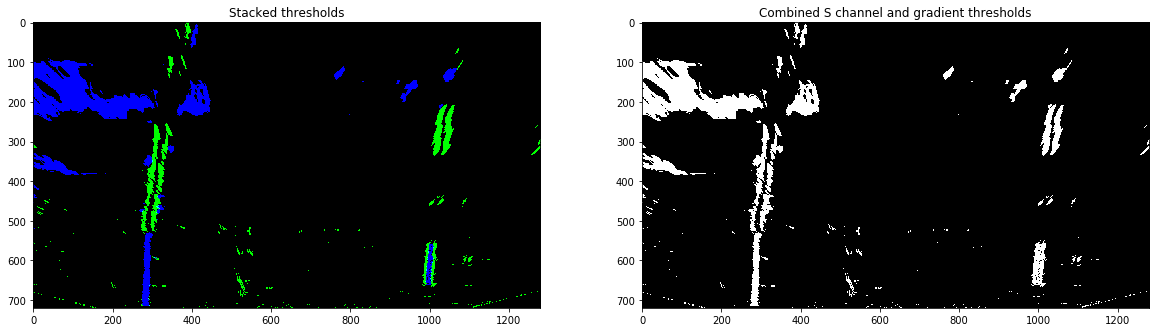

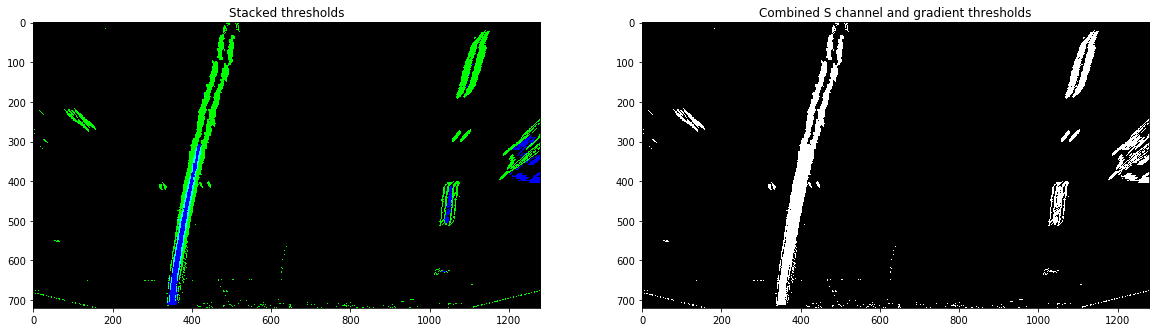

In [82]:
# Applying gradient and color channel filters to produce binary images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

images = glob.glob('./test_images/*.jpg')

binary_warped_images = []
for img in warped_images:
    # Read in an image, you can also try test1.jpg or test4.jpg
    # img = mpimg.imread(image)
    
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20 # 20
    thresh_max = 100 # 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170 # 170
    s_thresh_max = 255 # 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    binary_warped_images.append(combined_binary)
    
    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds')
    ax1.imshow(color_binary)
    
    ax2.set_title('Combined S channel and gradient thresholds')
    ax2.imshow(combined_binary, cmap='gray')

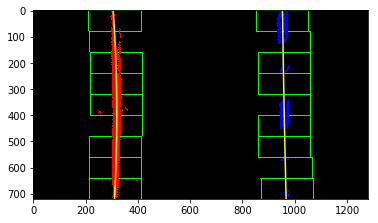

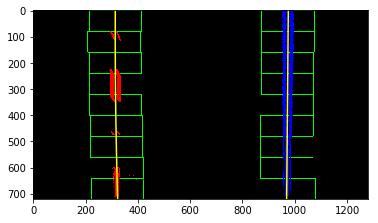

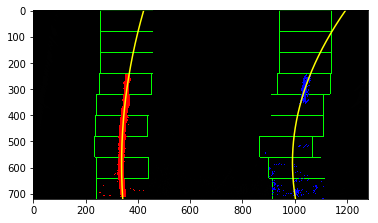

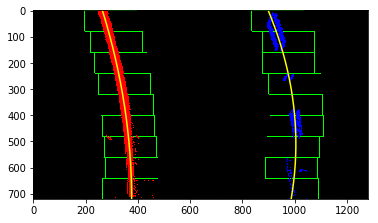

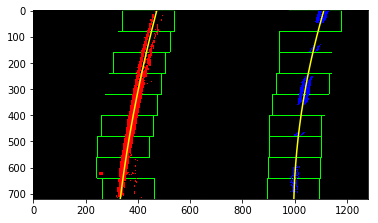

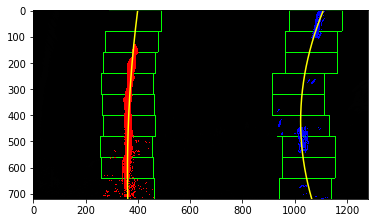

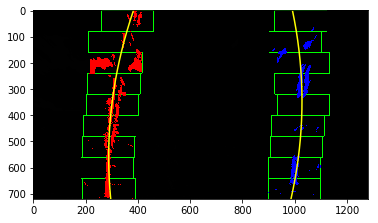

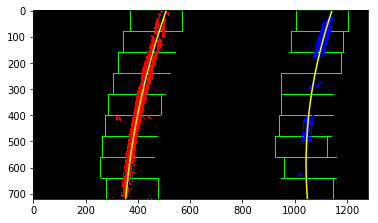

In [85]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    ## plt.plot(left_fitx, ploty, color='yellow')
    ## plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fitx, right_fitx, ploty

for img in binary_warped_images:
    plt.figure()
    out_img, left_fitx, right_fitx, ploty = fit_polynomial(img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.imshow(out_img)